In [1]:
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

#The below commented lines are for ResNet and VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

#from tensorflow.keras.applications import VGG16
#from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam


# ResNet and VGG16, img_width, img_height = 224, 224
img_width, img_height = 299, 299


NUM_EPOCHS = 5
batchsize = 10
num_train_images = 900
num_val_images = 100

#for ResNet, InceptionV3 will be replaced by ResNet50, for VGG, InceptionV3 will be replaced by VGG16

base_model = InceptionV3(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'furniture_images/train'


train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 1350 images belonging to 3 classes.


In [3]:
from keras.preprocessing.image import ImageDataGenerator

val_dir = 'furniture_images/val'


val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 156 images belonging to 3 classes.


In [4]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model

class_list = ["bed", "chair", "sofa"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

final_model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [5]:
adam = Adam(lr=0.00001)
final_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = final_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=0, 
                                       steps_per_epoch=num_train_images // batchsize, 
                                       shuffle=True, validation_data=val_generator,
        validation_steps=num_val_images // batchsize)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
90/90 [==============================] - 45s 498ms/step - loss: 0.9816 - accuracy: 0.5278 - val_loss: 0.8388 - val_accuracy: 0.7100
Epoch 2/5
90/90 [==============================] - 48s 532ms/step - loss: 0.7362 - accuracy: 0.7444 - val_loss: 0.5668 - val_accuracy: 0.8333
Epoch 3/5
90/90 [==============================] - 48s 537ms/step - loss: 0.5890 - accuracy: 0.8178 - val_loss: 0.5038 - val_accuracy: 0.8600
Epoch 4/5
90/90 [==============================] - 48s 535ms/step - loss: 0.5379 - accuracy: 0.8167 - val_loss: 0.4039 - val_accuracy: 0.8958
Epoch 5/5
90/90 [==============================] - 48s 535ms/step - loss: 0.4399 - accuracy: 0.8622 - val_loss: 0.4198 - val_accuracy: 0.8333


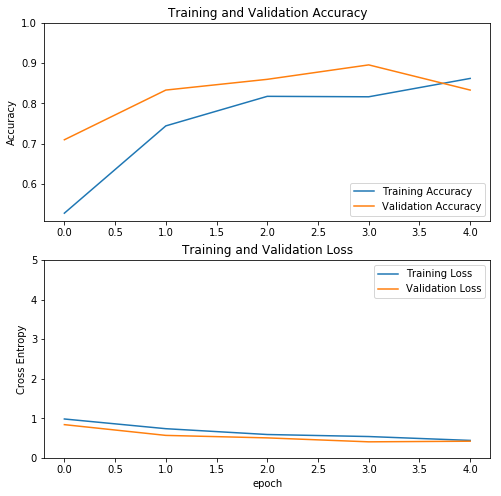

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
from keras.preprocessing import image
import numpy as np
# the below path shows the full path for uploaded image, adjust it for your specific path
img_path = 'furniture_images/train/bed/bed00000002train.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/chair/00000009.jpg'
#img_path ='/home/krish/visual_search/furniture-detector/img/train/sofa/00000016.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data1 = preprocess_input(img_data)

pretrained_feature = final_model.predict(img_data,verbose=0)
pretrained_feature_np = np.array(pretrained_feature)
pretrained_feature1D = pretrained_feature_np.flatten()

pretrained_feature_base = base_model.predict(img_data1)
pretrained_feature_np_base = np.array(pretrained_feature_base)
pretrained_feature1D_base = pretrained_feature_np_base.flatten()


print (pretrained_feature1D)
y_prob = final_model.predict(img_data)

y_classes = y_prob.argmax(axis=-1)

print(y_classes)



[0.52362007 0.12574324 0.3506367 ]
[0]


In [18]:
import os
from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity

# Below shows the full path for test images, adjust it for your specific path
if y_classes == [0]:
    path = 'furniture_images/val/bed'
elif y_classes == [1]:
    path = 'furniture_images/val/chair'
else:
    path = 'furniture_images/val/sofa'
    
mindist=10000
maxcosine =0
i=0
for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(img_width, img_height))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)

    pretrained_feature_train = base_model.predict(img_data_train)
    pretrained_feature_np_train = np.array(pretrained_feature_train)
    pretrained_feature_train1D = pretrained_feature_np_train.flatten()
    eucldist = dist.euclidean(pretrained_feature1D_base,pretrained_feature_train1D)
    
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
    #print (vgg16_feature_np)
    
    dot_product = np.dot(pretrained_feature1D_base,pretrained_feature_train1D)#normalize the results, to achieve similarity measures independant #of the scale of the vectors
    norm_Y = np.linalg.norm(pretrained_feature1D_base)
    norm_X = np.linalg.norm(pretrained_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    
    
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))


bedval31.jpg filename 270.373047 euclediandist 0.307542 cosine_similarity
bedval31.jpg minfilename 270.373047 mineuclediandist bedval31.jpg cosfilename 0.307542 maxcosinesimilarity
bedval13.jpg filename 180.725418 euclediandist 0.579325 cosine_similarity
bedval13.jpg minfilename 180.725418 mineuclediandist bedval13.jpg cosfilename 0.579325 maxcosinesimilarity
bedval02.jpg filename 215.062576 euclediandist 0.512424 cosine_similarity
bedval13.jpg minfilename 180.725418 mineuclediandist bedval13.jpg cosfilename 0.579325 maxcosinesimilarity
bedval20.jpg filename 216.781677 euclediandist 0.508705 cosine_similarity
bedval13.jpg minfilename 180.725418 mineuclediandist bedval13.jpg cosfilename 0.579325 maxcosinesimilarity
bedval18.jpg filename 217.557190 euclediandist 0.493734 cosine_similarity
bedval13.jpg minfilename 180.725418 mineuclediandist bedval13.jpg cosfilename 0.579325 maxcosinesimilarity
bedval41.jpg filename 261.918274 euclediandist 0.323449 cosine_similarity
bedval13.jpg minfilen

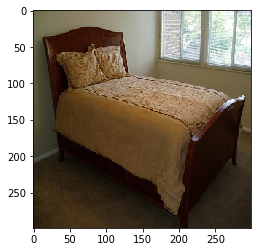

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 0.6709984')

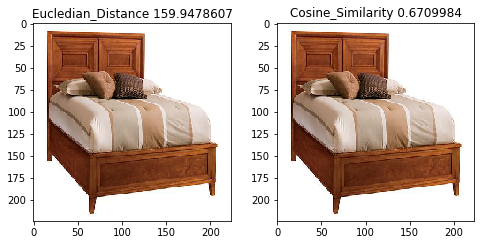

In [20]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Eucledian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))